## Agent-Customer Conversation Topic Classification

### Refrence <br>
https://monkeylearn.com/blog/introduction-to-topic-modeling/ <br>
<h4>classification and implimentation ref</h4>
https://towardsdatascience.com/working-with-hugging-face-transformers-and-tf-2-0-89bf35e3555a

In [2]:
import os
import io
import re
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [3]:
os.chdir('/content/drive/MyDrive/projects_assignment/idfy_nlp_assignment')
os.getcwd()

'/content/drive/MyDrive/projects_assignment/idfy_nlp_assignment'

Dictionary for expanding the contracted words

In [4]:
CONTRACTION_MAP = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" 
                   }

### Data Cleaning
Different helper methods to clean and Prepare the data

In [345]:
def clean_script(script_text):
  'This method takes the script_text:string as an input and returns the same after cleaning'

  # print(script_text)
  script_text = script_text.lower()

  #removes the token like '[silence]' or [']
  script_text = re.sub('[\[[a-z]*\-[a-z]*]|[\[[a-z]*]', ' ', script_text)

  #this removes all the extra whitespace
  script_text = re.sub('[\s]{2,}', ' ',script_text)

  #this removes the repeating 'yeah'. As this token is important so removing the repeating one
  #what is does that it replace the yeah yeah with yeah or yeah yeah yeah with yeah and so on
  script_text = re.sub('yeah\syeah|yeah\syeah\syeah|yeah\syeah\syeah\syeah|yeah\syeah\syeah\syeah\syeah', 'yeah', script_text)
  script_text = re.sub('[\s]{2,}', ' ',script_text)
  script_text = re.sub('yeah\syeah|yeah\syeah\syeah|yeah\syeah\syeah\syeah|yeah\syeah\syeah\syeah\syeah', 'yeah', script_text)

  #this removes the 'um', 'uh', 'um-hum', 'i-', '-i' or '-' from the script as alomst useless. As these are repeating alot and not adding much of value 
  script_text = re.sub('um|uh|]\s\w\-|\-\s|\-\w|\w\-', '',script_text)

  #removing tag like <b_aside> or <e_aside>
  script_text = re.sub('<.*?>' ,'', script_text)

  #this removes all the extra whitespace
  script_text = re.sub('[\s]{2,}', ' ',script_text)
  return ' '+script_text.strip()

def pre_process_conv_script(txt_file): 
  'This method takes the conversation script file_path as input and returns the cleaned string'

  #we'll get the file id from the text file name - will be used later to build the train and test dataset
  file_id_search = re.search('[0-9]+', txt_file)
  file_id = txt_file[file_id_search.start():file_id_search.end()]

  final_str = ''
  script_lines = io.open(txt_file,encoding='UTF-8').read().split('\n')
  for script in script_lines:
    script = ' '.join(script.split(' ')[3:])
   
    script = clean_script(script)
    
    final_str += script

  #just removes extra white spaces
  final_str = re.sub('[\s]{2,}', ' ',final_str)

  return final_str.strip(), file_id
    

In [375]:
# Prepare Data 
# For classical ML approach like Bow / tfidf we'll have to prepare the data with expanded contractions eg. 'don't' to 'do not'
def expand_contraction(cleaned_script, key, value):
  'This method expands the contracted word. Takes words, key and value as an input'
  cleaned_script = re.sub(key, value, cleaned_script)
  return cleaned_script

# Modern state of the art algorithms like Bert do not care wether word is contracted or uncontracted. 

def prep_data():
  'This method prepares the data. returns the label_list and list of cleaned conversation script'
  #this list stores all the clean conv script
  clean_script_list = []
  clean_script_uncontracted = []
  label_list = []
  
  # Storing all text files in a list
  text_files = os.listdir('tagging_test')[:-1]
  contraction_keys  = list(CONTRACTION_MAP.keys())
  
  for text_file in text_files:
    # get the clean text for each text file
    clean_script, label_id = pre_process_conv_script('tagging_test/'+text_file)
    clean_script_list.append(clean_script)
    label_list.append(label_id)

    for key in contraction_keys:
      clean_script = expand_contraction(clean_script, key, CONTRACTION_MAP.get(key))
    clean_script_uncontracted.append(clean_script)

  return label_list, clean_script_list, clean_script_uncontracted


In [376]:
label_list, clean_script_list, clean_script_uncontracted = prep_data()

### Building dataframe
We'll prepare data out of list returned by prep_data

In [381]:
#prep pandas dataframe out of it
data_uncontracted = pd.DataFrame(data=list(zip(label_list, clean_script_uncontracted)), columns = ['label_id', 'conv_script'])
data_contracted  = pd.DataFrame(data=list(zip(label_list, clean_script_list)), columns = ['label_id', 'conv_script'])

In [383]:
data_uncontracted.sample(10)

,label_id,conv_script
170,4615,why do not you go ahead first okay short term ...
165,4383,do you think should be done for the the huge b...
103,2478,colorado springs oh right up in ti out there y...
22,2092,well the thing is is that since i am in school...
106,2591,the whole savings and loan thing seems to be a...
46,2235,okay hi okay you wanna start hi yeah sure i th...
217,2791,okay official time well what do you think of a...
4,3077,americans like me and whether or not not i thi...
81,4240,so how do you like the benefits of ti well act...
147,2916,okay i do not think i have ever met anybody th...


In [384]:
data_contracted.sample(10)

,label_id,conv_script
22,2092,well the thing is is that since i'm in school ...
216,2447,probably the lifestyles and the size of the ar...
21,2234,well my family moved to texas about eight year...
8,3312,kind of options do you have in your work as fa...
130,2782,i guess so okay ready to talk okay i want to t...
54,3084,okay i guess we're going to talk about budgets...
167,3786,o okay so you were with ti h yeah i've been wi...
117,2508,how do you manage your budget well let's see w...
95,2917,hi what do you do with your credit cards oh we...
39,2250,so what kind of benefits do you have in your j...


In [388]:
os.getcwd()

'/content/drive/My Drive/projects_assignment/idfy_nlp_assignment'

### Preparing class labels
Since class labels for each conversation script is in different files so we'll have to process those all

In [413]:
#now let's process the label text file and conact that with script dataFrame
def prep_label():
  'This methods prepares the lis of labels and label ids'
  all_labels_list = []
  all_labels_id = []

  path_to_file = 'tagging_test/metadata/mapping_conv_topic.train.txt'
  label_lines = io.open(path_to_file,encoding='UTF-8').read().split('\n')

  for label_line in label_lines:
    
    try:
      all_labels_id.append(label_line.split()[0])
      all_labels_list.append(re.sub('"', '', ' '.join(label_line.split()[1:])))
    #putting exception block as few problem with the text file in last line. So all good with exception
    except:
      continue
    
    
  return all_labels_list, all_labels_id


In [414]:
all_labels_list, all_labels_id = prep_label()

In [ ]:
#### 

Building dataframe for the class labels

In [416]:
data_label  = pd.DataFrame(data=list(zip(all_labels_id, all_labels_list)), columns = ['label_id', 'class_label'])
data_label.sample(5)

,label_id,class_label
142,4254,Job Benefits
16,2800,Credit Card
102,2129,Job Benefits
49,2327,Taxes
208,4379,Family Finance


### Merging class labels and Conversation Scripts together

In [421]:
#concatinatng Labels dataframe with the script
data_uncontracted = data_uncontracted.merge(data_label)
data_uncontracted

,label_id,conv_script,class_label
0,4160,so do you keep a family budget well not a real...,Family Finance
1,3196,hello hello hi boy it took forever to find som...,Credit Card
2,2424,there we go okay well what do you think about ...,Taxes
3,3270,well i do not know if there is gonna be a solu...,Budget
4,3077,americans like me and whether or not not i thi...,Taxes
...,...,...,...
235,3673,you keep a budget yes i do okay how do you wor...,Family Finance
236,4031,is all you need h i think just one is all you ...,Family Finance
237,4209,jeff what do you think are you paying to much ...,Taxes
238,4222,cathy i am in boston hi i am ralph cincinnati ...,Taxes


In [422]:
#concatinatng Labels dataframe with the script
data_contracted = data_contracted.merge(data_label)
data_contracted

,label_id,conv_script,class_label
0,4160,so do you keep a family budget well not a real...,Family Finance
1,3196,hello hello hi boy it took forever to find som...,Credit Card
2,2424,there we go okay well what do you think about ...,Taxes
3,3270,well i don't know if there's gonna be a soluti...,Budget
4,3077,americans like me and whether or not not i thi...,Taxes
...,...,...,...
235,3673,you keep a budget yes i do okay how do you wor...,Family Finance
236,4031,is all you need h i think just one is all you ...,Family Finance
237,4209,jeff what do you think are you paying to much ...,Taxes
238,4222,cathy i'm in boston hi i'm ralph cincinnati hi...,Taxes


Dumping files to the local disk to reload in future

In [5]:
import pickle

In [111]:
# Save all the on the disk to avoid re computation 
#pickle.dump((data_contracted, data_uncontracted),open('clean_data_with_label.pkl','wb'))

# Loading 
data_contracted, data_uncontracted= pickle.load(open('clean_data_with_label.pkl', 'rb'))

### Basic Analysis on Data
We'll have a look at class distribution 

In [112]:
# we'll do basic data Analysis

# Looking at class distribution
data_uncontracted.class_label.value_counts()


Family Finance    63
Taxes             54
Job Benefits      54
Credit Card       41
Budget            22
Bank Bailout       6
Name: class_label, dtype: int64

we can see Bank Bailout is minor class here with just 6 examples. We'll have to look at this label while building model. <br>

#### Let's visualize the class distribution

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


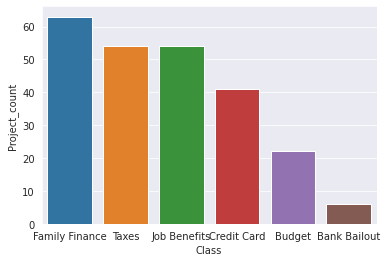

In [113]:
class_plot = data_uncontracted.class_label.value_counts()
sns.set_style('darkgrid')
sns.barplot(class_plot.index, class_plot.values)
plt.xlabel("Class")
plt.ylabel("Project_count")
plt.show()

#### Doing analysis on conversation Script

In [114]:
# like getting average size of conv script

uncontracted_lengths = data_uncontracted['conv_script'].str.split().apply(len)
contracted_lengths = data_contracted['conv_script'].str.split().apply(len)



print('*******Conv Script with contracted words ***********')

for i in range(0, 101,10):
  print(i, 'percentile', np.percentile(contracted_lengths, i))
print('\n')
for i in range(90, 102,2):
  print(i, 'percentile', np.percentile(contracted_lengths, i))
print('\n')
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
  print(i, 'percentile', np.percentile(contracted_lengths, i))

print('\n')


print('*******Conv Script with uncontracted words***********')

for i in range(0, 101,10):
  print(i, 'percentile', np.percentile(uncontracted_lengths, i))
print('\n')
for i in range(90, 102,2):
  print(i, 'percentile', np.percentile(uncontracted_lengths, i))
print('\n')
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
  print(i, 'percentile', np.percentile(uncontracted_lengths, i))

*******Conv Script with contracted words ***********
0 percentile 557.0
10 percentile 796.0
20 percentile 844.8000000000001
30 percentile 893.7
40 percentile 927.6
50 percentile 996.0
60 percentile 1063.6
70 percentile 1351.3999999999996
80 percentile 1621.0000000000007
90 percentile 1898.1
100 percentile 2249.0


90 percentile 1898.1
92 percentile 1923.52
94 percentile 2000.86
96 percentile 2074.2
98 percentile 2113.7200000000003
100 percentile 2249.0


99.1 percentile 2207.617999999999
99.2 percentile 2222.3759999999997
99.3 percentile 2228.8289999999997
99.4 percentile 2235.282000000001
99.5 percentile 2241.735
99.6 percentile 2247.088
99.7 percentile 2247.566
99.8 percentile 2248.044
99.9 percentile 2248.522
100 percentile 2249.0


*******Conv Script with uncontracted words***********
0 percentile 594.0
10 percentile 840.3
20 percentile 887.0
30 percentile 935.7
40 percentile 976.6
50 percentile 1042.5
60 percentile 1115.0
70 percentile 1422.3
80 percentile 1697.400000000001
90 per

As we can see above each converation script is fairy large.

### Prepare data for Models

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import  preprocessing
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
import math

#### Train, Test dataset

In [116]:
#we'll have to split into train and test data
X_train, X_test, y_train, y_test = train_test_split(data_uncontracted['conv_script'], data_uncontracted['class_label'], test_size=0.30, stratify=data_uncontracted['class_label'])
print(X_train.shape, X_test.shape)

(168,) (72,)


In [117]:
y_train.value_counts()

Family Finance    44
Taxes             38
Job Benefits      38
Credit Card       29
Budget            15
Bank Bailout       4
Name: class_label, dtype: int64

In [118]:
y_test.value_counts()

Family Finance    19
Taxes             16
Job Benefits      16
Credit Card       12
Budget             7
Bank Bailout       2
Name: class_label, dtype: int64

#### Converting text to vector representation

In [ ]:
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
print(stopwords.words('english'))

In [119]:
stopwords_list = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 
                  'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 
                  'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was',
                  'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 
                  'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 
                  'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 
                  'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'only', 
                  'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 
                  've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 
                  'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', 
                  "weren't", 'won', "won't", 'wouldn', "wouldn't"]

Initializing  count vectorizer

In [215]:
# BoW vector representaion for the Conv Script
del uncontracted_vectorizer
uncontracted_vectorizer = CountVectorizer(stop_words=stopwords_list, max_features= 60000)
uncontracted_vectorizer.fit(X_train.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=60000, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

Converting text to Numeric vector with vectorizer

In [217]:

X_train_bow = uncontracted_vectorizer.transform(X_train.values)
X_test_bow = uncontracted_vectorizer.transform(X_test.values)

#### Converting class labels to numerical representation

In [218]:
# Also convert classes into categories
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(y_train)

LabelEncoder()

In [219]:
label_encoder.classes_

array(['Bank Bailout', 'Budget', 'Credit Card', 'Family Finance',
       'Job Benefits', 'Taxes'], dtype=object)

In [220]:
train_y = label_encoder.transform(y_train.values)
test_y = label_encoder.transform(y_test.values)

In [221]:
train_y.shape

(168,)

# Only experiments 
For final look over final notebook
## Naive Bayse

In [223]:
#this model with 6193 vocab size

#CV
alpha_cv = []     #stores log(alpha) for plotting
auc_cv = []    #stores auc value Test

alpha_ = []  #stores alpha vaslue

alpha_tr = []     #stores log(alpha) for plotting 
auc_tr = []       #stores AUC Score on Train

i = 0.00001 #alpha value starting range

while i<=1000:   
    NB = MultinomialNB(alpha = i)
    ovr_NB = OneVsRestClassifier(NB)    
    ovr_NB.fit(X_train_bow, train_y)
    
    #Train Data
    predicted = ovr_NB.predict_proba(X_train_bow)   #returns probablity score
    # print(predicted.shape)
    auc = metrics.roc_auc_score(train_y, predicted[:, :], multi_class='ovr')
    auc_tr.append(auc)
    alpha_tr.append(math.log(i))
    
    # #Cv Data
    predicted_ = ovr_NB.predict_proba(X_test_bow)   #returns probablity score
    # print(predicted_.shape)
    auc_ = metrics.roc_auc_score(test_y, predicted_[:, :], multi_class='ovr')
    auc_cv.append(auc_)
    alpha_cv.append(math.log(i))
    
    
    alpha_.append(i)
    
    i *= 10
    
    
#printing the alpha and corresponding AUC value
print("AUC Score on CV:")
for x in range(0, len(alpha_)):
    print("Alpha: {}, AUC: {}".format(alpha_[x], auc_cv[x]))

print("\nAUC Score on Train:")
for x in range(0, len(alpha_)):
    print("Alpha: {}, AUC: {}".format(alpha_[x], auc_tr[x]))

AUC Score on CV:
Alpha: 1e-05, AUC: 0.8833947313605331
Alpha: 0.0001, AUC: 0.8912660556381075
Alpha: 0.001, AUC: 0.9257521558302809
Alpha: 0.01, AUC: 0.9692374465811966
Alpha: 0.1, AUC: 0.9824027968559218
Alpha: 1.0, AUC: 0.9259736212861213
Alpha: 10.0, AUC: 0.8426978703511722
Alpha: 100.0, AUC: 0.8283195124462504
Alpha: 1000.0, AUC: 0.8090433453159992

AUC Score on Train:
Alpha: 1e-05, AUC: 1.0
Alpha: 0.0001, AUC: 1.0
Alpha: 0.001, AUC: 1.0
Alpha: 0.01, AUC: 1.0
Alpha: 0.1, AUC: 1.0
Alpha: 1.0, AUC: 1.0
Alpha: 10.0, AUC: 0.9480538430498046
Alpha: 100.0, AUC: 0.8689959138014496
Alpha: 1000.0, AUC: 0.839068445944299


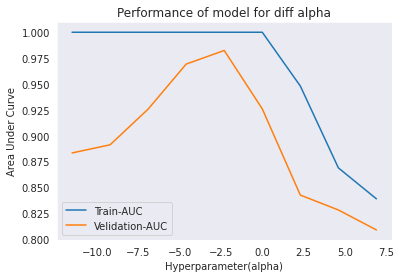

In [224]:
plt.plot(alpha_tr, auc_tr, label="Train-AUC")
plt.plot(alpha_cv, auc_cv, label="Velidation-AUC")
plt.xlabel("Hyperparameter(alpha)")
plt.ylabel("Area Under Curve"); plt.title("Performance of model for diff alpha")
plt.legend()
plt.grid()
plt.show()

In [225]:
# train final model with optimal alpha = 0.1
NB = MultinomialNB(alpha = 0.1)
ovr_NB = OneVsRestClassifier(NB)    
ovr_NB.fit(X_train_bow, train_y)

#Train Data
predicted = ovr_NB.predict_proba(X_train_bow)   #returns probablity score
# print(predicted.shape)
auc = metrics.roc_auc_score(train_y, predicted[:, :], multi_class='ovr')
print('AUC with alpha = 0.1 on train : ', auc)

# #Cv Data
predicted_ = ovr_NB.predict_proba(X_test_bow)   #returns probablity score
# print(predicted_.shape)
auc_ = metrics.roc_auc_score(test_y, predicted_[:, :], multi_class='ovr')
print('AUC with alpha = 0.1 on test : ', auc_)

AUC with alpha = 0.1 on train :  1.0
AUC with alpha = 0.1 on test :  0.9824027968559218


In [226]:
y_test.value_counts()

Family Finance    19
Taxes             16
Job Benefits      16
Credit Card       12
Budget             7
Bank Bailout       2
Name: class_label, dtype: int64

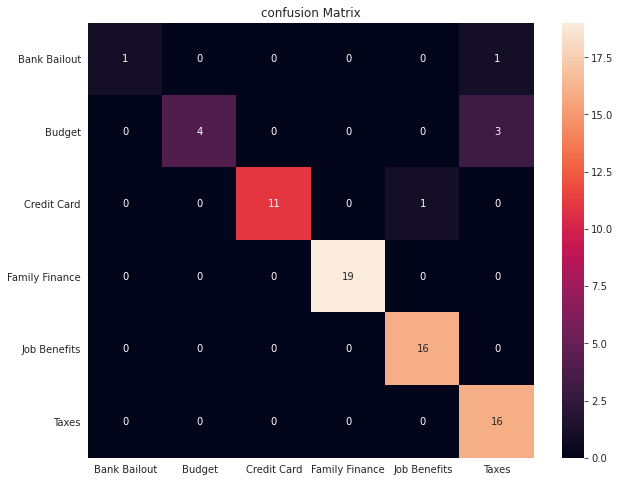

In [227]:
#confusion maetrics too see what happening
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
predict = ovr_NB.predict(X_test_bow)
cm = metrics.confusion_matrix(test_y, predict)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, xticklabels=target_label, yticklabels=target_label)
plt.title('confusion Matrix')
plt.show()

here AUC is good and model is also doing failry well on all of the class except on 'budget' class

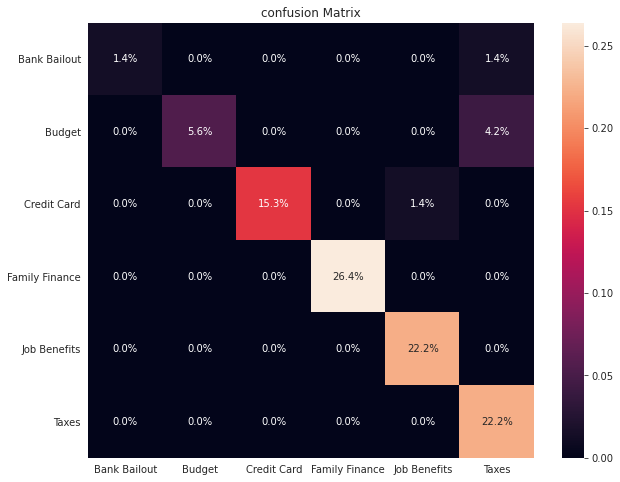

In [228]:
cm = metrics.confusion_matrix(test_y, predict)
plt.figure(figsize=(10, 8))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.01%', xticklabels=target_label, yticklabels=target_label)
plt.title('confusion Matrix')
plt.show()

### Model
#### Hyperparameter tunning the Niave Bayse

In [169]:
#this model with 6193 vocab size

#CV
alpha_cv = []     #stores log(alpha) for plotting
auc_cv = []    #stores auc value Test

alpha_ = []  #stores alpha vaslue

alpha_tr = []     #stores log(alpha) for plotting 
auc_tr = []       #stores AUC Score on Train

i = 0.00001 #alpha value starting range

while i<=1000:   
    NB = MultinomialNB(alpha = i)
    ovr_NB = OneVsRestClassifier(NB)    
    ovr_NB.fit(X_train_bow, train_y)
    
    #Train Data
    predicted = ovr_NB.predict_proba(X_train_bow)   #returns probablity score
    # print(predicted.shape)
    auc = metrics.roc_auc_score(train_y, predicted[:, :], multi_class='ovr')
    auc_tr.append(auc)
    alpha_tr.append(math.log(i))
    
    # #Cv Data
    predicted_ = ovr_NB.predict_proba(X_test_bow)   #returns probablity score
    # print(predicted_.shape)
    auc_ = metrics.roc_auc_score(test_y, predicted_[:, :], multi_class='ovr')
    auc_cv.append(auc_)
    alpha_cv.append(math.log(i))
    
    
    alpha_.append(i)
    
    i *= 10
    
    
#printing the alpha and corresponding AUC value
print("AUC Score on CV:")
for x in range(0, len(alpha_)):
    print("Alpha: {}, AUC: {}".format(alpha_[x], auc_cv[x]))

print("\nAUC Score on Train:")
for x in range(0, len(alpha_)):
    print("Alpha: {}, AUC: {}".format(alpha_[x], auc_tr[x]))

AUC Score on CV:
Alpha: 1e-05, AUC: 0.8809021718367237
Alpha: 0.0001, AUC: 0.8896736365486365
Alpha: 0.001, AUC: 0.9219813606532358
Alpha: 0.01, AUC: 0.9725773936711436
Alpha: 0.1, AUC: 0.9875713840557592
Alpha: 1.0, AUC: 0.9742715328652829
Alpha: 10.0, AUC: 0.953750445156695
Alpha: 100.0, AUC: 0.9452984989409704
Alpha: 1000.0, AUC: 0.9449242389279319

AUC Score on Train:
Alpha: 1e-05, AUC: 1.0
Alpha: 0.0001, AUC: 1.0
Alpha: 0.001, AUC: 1.0
Alpha: 0.01, AUC: 1.0
Alpha: 0.1, AUC: 1.0
Alpha: 1.0, AUC: 1.0
Alpha: 10.0, AUC: 0.9977001984378067
Alpha: 100.0, AUC: 0.9887389878235773
Alpha: 1000.0, AUC: 0.9821700417274698


In [170]:
predicted_[0:1, :].shape

(1, 6)

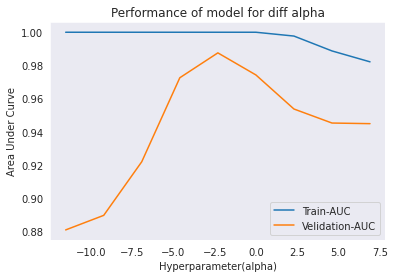

In [171]:
plt.plot(alpha_tr, auc_tr, label="Train-AUC")
plt.plot(alpha_cv, auc_cv, label="Velidation-AUC")
plt.xlabel("Hyperparameter(alpha)")
plt.ylabel("Area Under Curve"); plt.title("Performance of model for diff alpha")
plt.legend()
plt.grid()
plt.show()

The optimal value for alpha = 0.1 for that we have max AUC score

In [172]:
# train final model with optimal alpha = 0.1
NB = MultinomialNB(alpha = 0.1)
ovr_NB = OneVsRestClassifier(NB)    
ovr_NB.fit(X_train_bow, train_y)

#Train Data
predicted = ovr_NB.predict_proba(X_train_bow)   #returns probablity score
# print(predicted.shape)
auc = metrics.roc_auc_score(train_y, predicted[:, :], multi_class='ovr')
print('AUC with alpha = 0.1 on train : ', auc)

# #Cv Data
predicted_ = ovr_NB.predict_proba(X_test_bow)   #returns probablity score
# print(predicted_.shape)
auc_ = metrics.roc_auc_score(test_y, predicted_[:, :], multi_class='ovr')
print('AUC with alpha = 0.1 on test : ', auc_)

AUC with alpha = 0.1 on train :  1.0
AUC with alpha = 0.1 on test :  0.9875713840557592


In [173]:
y_test.value_counts()

Family Finance    19
Taxes             16
Job Benefits      16
Credit Card       12
Budget             7
Bank Bailout       2
Name: class_label, dtype: int64

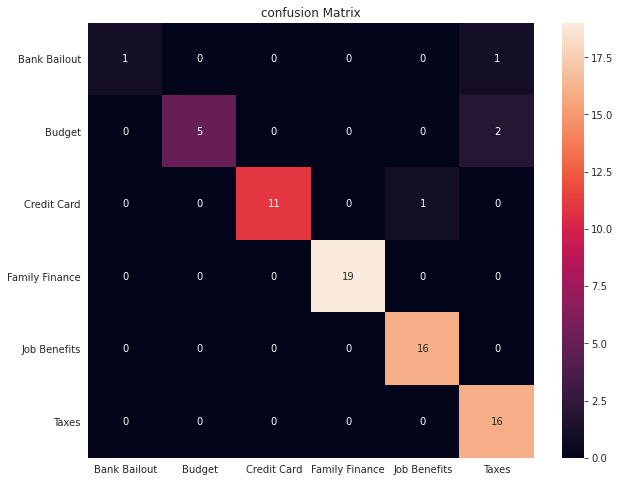

In [174]:
#confusion maetrics too see what happening
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
predict = ovr_NB.predict(X_test_bow)
cm = metrics.confusion_matrix(test_y, predict)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, xticklabels=target_label, yticklabels=target_label)
plt.title('confusion Matrix')
plt.show()

So here we can see, this model is fairly good at minor class compare to others. AUC score is highest here.

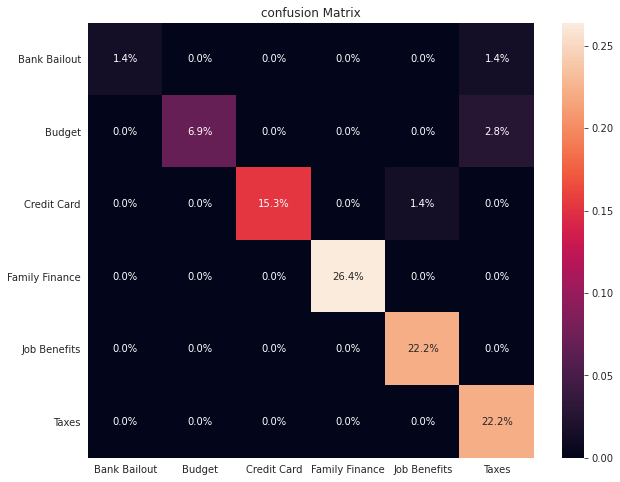

In [175]:
cm = metrics.confusion_matrix(test_y, predict)
plt.figure(figsize=(10, 8))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.01%', xticklabels=target_label, yticklabels=target_label)
plt.title('confusion Matrix')
plt.show()

In [176]:
#save this model on disk
pickle.dump((ovr_NB),open('nb_over_optimal_2.pkl','wb'))

# to reload the model
#ovr_NB = pickle.load(open("nb_over_optimal.pkl", 'rb'))

#saving vectorizer
pickle.dump((uncontracted_vectorizer),open('nb_uncontracted_vectorizer_2.pkl','wb'))

#saving label encoder
pickle.dump((label_encoder),open('nb_uncontracted_label_encoder_2.pkl','wb'))

In [96]:
# I removed those stopwords that's why the vocab size so the vector dimentionality is only 6k

In [97]:
#this model with 6249 vocab size

#CV
alpha_cv = []     #stores log(alpha) for plotting
auc_cv = []    #stores auc value Test

alpha_ = []  #stores alpha vaslue

alpha_tr = []     #stores log(alpha) for plotting 
auc_tr = []       #stores AUC Score on Train

i = 0.00001 #alpha value starting range

while i<=1000:   
    NB = MultinomialNB(alpha = i)
    ovr_NB = OneVsRestClassifier(NB)    
    ovr_NB.fit(X_train_bow, train_y)
    
    #Train Data
    predicted = ovr_NB.predict_proba(X_train_bow)   #returns probablity score
    # print(predicted.shape)
    auc = metrics.roc_auc_score(train_y, predicted[:, :], multi_class='ovr')
    auc_tr.append(auc)
    alpha_tr.append(math.log(i))
    
    # #Cv Data
    predicted_ = ovr_NB.predict_proba(X_test_bow)   #returns probablity score
    # print(predicted_.shape)
    auc_ = metrics.roc_auc_score(test_y, predicted_[:, :], multi_class='ovr')
    auc_cv.append(auc_)
    alpha_cv.append(math.log(i))
    
    
    alpha_.append(i)
    
    i *= 10
    
    
#printing the alpha and corresponding AUC value
print("AUC Score on CV:")
for x in range(0, len(alpha_)):
    print("Alpha: {}, AUC: {}".format(alpha_[x], auc_cv[x]))

print("\nAUC Score on Train:")
for x in range(0, len(alpha_)):
    print("Alpha: {}, AUC: {}".format(alpha_[x], auc_tr[x]))

AUC Score on CV:
Alpha: 1e-05, AUC: 0.8758976762530014
Alpha: 0.0001, AUC: 0.8892343518611984
Alpha: 0.001, AUC: 0.8603708791208792
Alpha: 0.01, AUC: 0.9806175595238096
Alpha: 0.1, AUC: 0.9867216117216118
Alpha: 1.0, AUC: 0.9048138874944982
Alpha: 10.0, AUC: 0.8106746933553041
Alpha: 100.0, AUC: 0.8072058150183151
Alpha: 1000.0, AUC: 0.8064565156996264

AUC Score on Train:
Alpha: 1e-05, AUC: 1.0
Alpha: 0.0001, AUC: 1.0
Alpha: 0.001, AUC: 1.0
Alpha: 0.01, AUC: 1.0
Alpha: 0.1, AUC: 1.0
Alpha: 1.0, AUC: 1.0
Alpha: 10.0, AUC: 0.9352158969522074
Alpha: 100.0, AUC: 0.8717885449134205
Alpha: 1000.0, AUC: 0.8504471700113984


In [98]:
predicted_[0:1, :].shape

(1, 6)

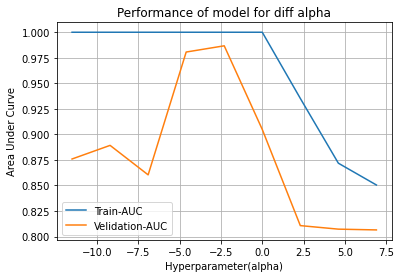

In [99]:
plt.plot(alpha_tr, auc_tr, label="Train-AUC")
plt.plot(alpha_cv, auc_cv, label="Velidation-AUC")
plt.xlabel("Hyperparameter(alpha)")
plt.ylabel("Area Under Curve"); plt.title("Performance of model for diff alpha")
plt.legend()
plt.grid()
plt.show()

In [129]:
# train final model with optimal alpha = 0.1
NB = MultinomialNB(alpha = 0.1)
ovr_NB = OneVsRestClassifier(NB)    
ovr_NB.fit(X_train_bow, train_y)

#Train Data
predicted = ovr_NB.predict_proba(X_train_bow)   #returns probablity score
# print(predicted.shape)
auc = metrics.roc_auc_score(train_y, predicted[:, :], multi_class='ovr')
print('AUC with alpha = 0.1 on train : ', auc)

# #Cv Data
predicted_ = ovr_NB.predict_proba(X_test_bow)   #returns probablity score
# print(predicted_.shape)
auc_ = metrics.roc_auc_score(test_y, predicted_[:, :], multi_class='ovr')
print('AUC with alpha = 0.1 on test : ', auc_)

AUC with alpha = 0.1 on train :  1.0
AUC with alpha = 0.1 on test :  0.9824027968559218


In [130]:
y_test.value_counts().values / y_test.value_counts().values.sum()

array([0.26388889, 0.22222222, 0.22222222, 0.16666667, 0.09722222,
       0.02777778])

In [131]:
y_test.value_counts()

Family Finance    19
Taxes             16
Job Benefits      16
Credit Card       12
Budget             7
Bank Bailout       2
Name: class_label, dtype: int64

In [132]:
target_label = list(label_encoder.classes_)

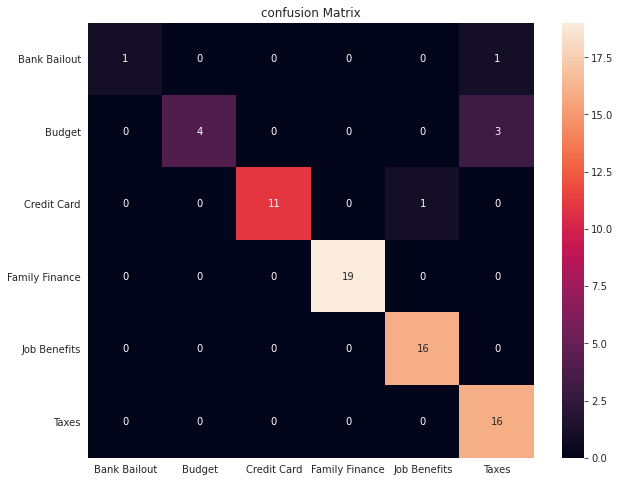

In [133]:
#confusion maetrics too see what happening
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
predict = ovr_NB.predict(X_test_bow)
cm = metrics.confusion_matrix(test_y, predict)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, xticklabels=target_label, yticklabels=target_label)
plt.title('confusion Matrix')
plt.show()

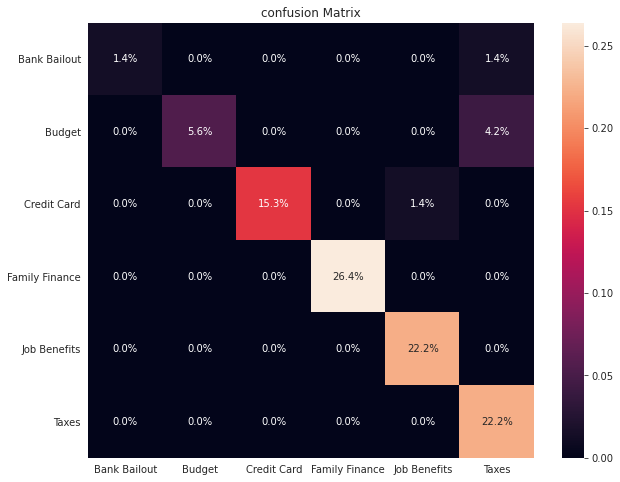

In [134]:
cm = metrics.confusion_matrix(test_y, predict)
plt.figure(figsize=(10, 8))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.01%', xticklabels=target_label, yticklabels=target_label)
plt.title('confusion Matrix')
plt.show()

In [135]:
#save this model on disk
pickle.dump((ovr_NB),open('nb_over_optimal.pkl','wb'))

# to reload the model
#ovr_NB = pickle.load(open("nb_over_optimal.pkl", 'rb'))

#saving vectorizer
pickle.dump((uncontracted_vectorizer),open('nb_uncontracted_vectorizer.pkl','wb'))

#saving label encoder
pickle.dump((label_encoder),open('nb_uncontracted_label_encoder.pkl','wb'))

In [136]:
#saving vectorizer
pickle.dump((uncontracted_vectorizer),open('nb_uncontracted_vectorizer.pkl','wb'))

In [137]:
#saving label encoder
pickle.dump((label_encoder),open('nb_uncontracted_label_encoder.pkl','wb'))

In [138]:
# We'll get feature importance

## logisitc Regression

In [ ]:
#logistic regression and see how does it work - main goal is to have a model which works fairly good on 'Budget' and 'Bank Bailout' samples

In [561]:
from sklearn.linear_model import SGDClassifier

In [587]:
#define SGD classifier

#AUC on Train & CV
cv_auc = []
tr_auc = []

c_list = []
c_log = []

i = 10**-4
while i<=1000:
    log_clsfr = SGDClassifier(loss='log', alpha=i, penalty='l2',learning_rate='adaptive', eta0=0.01)
    log_clsfr_ovr = OneVsRestClassifier(log_clsfr)
    log_clsfr_ovr.fit(X_train_bow, train_y)
    
    #Train
    proba_score = log_clsfr_ovr.predict_proba(X_train_bow)
    auc = metrics.roc_auc_score(train_y, proba_score[:, :], multi_class='ovr')
    tr_auc.append(auc)
    
    #Velidation
    proba_score_ = log_clsfr_ovr.predict_proba(X_test_bow)
    auc_ = metrics.roc_auc_score(test_y, proba_score_[:, :], multi_class='ovr')
    cv_auc.append(auc_)
    
    #Storing C and log(c) to list
    c_list.append(i)
    c_log.append(math.log(i))
    
    i*=10

#Displaying message to Output
print("AUC Score on Train")
for i in range(0, len(tr_auc)):
    print("C:{}, Lambda:{}, AUC:{}".format(c_list[i], 1/c_list[i], tr_auc[i]))
    
print("\nAUC Score on Velidation")
for i in range(0, len(cv_auc)):
    print("C:{}, Lambda:{}, AUC:{}".format(c_list[i], 1/c_list[i], cv_auc[i]))

AUC Score on Train
C:0.0001, Lambda:10000.0, AUC:1.0
C:0.001, Lambda:1000.0, AUC:1.0
C:0.01, Lambda:100.0, AUC:1.0
C:0.1, Lambda:10.0, AUC:1.0
C:1.0, Lambda:1.0, AUC:1.0
C:10.0, Lambda:0.1, AUC:0.9686588440161996
C:100.0, Lambda:0.01, AUC:0.8245623749783108
C:1000.0, Lambda:0.001, AUC:0.7132171733526733

AUC Score on Velidation
C:0.0001, Lambda:10000.0, AUC:0.9371757940650692
C:0.001, Lambda:1000.0, AUC:0.9265552779657175
C:0.01, Lambda:100.0, AUC:0.9663415276646098
C:0.1, Lambda:10.0, AUC:0.9280880843279986
C:1.0, Lambda:1.0, AUC:0.9444353771159878
C:10.0, Lambda:0.1, AUC:0.8847097797484155
C:100.0, Lambda:0.01, AUC:0.8030378013247924
C:1000.0, Lambda:0.001, AUC:0.7075105399009942


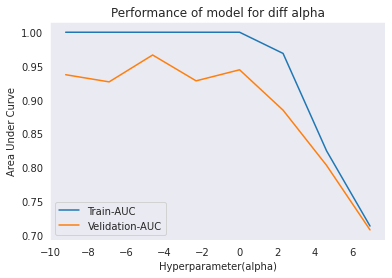

In [588]:
plt.plot(c_log, tr_auc, label="Train-AUC")
plt.plot(c_log, cv_auc, label="Velidation-AUC")
plt.xlabel("Hyperparameter(alpha)")
plt.ylabel("Area Under Curve"); plt.title("Performance of model for diff alpha")
plt.legend()
plt.grid()
plt.show()

In [589]:
# finally we'll train a model with optimal alpha = 

log_clsfr = SGDClassifier(loss='log', alpha=0.01, penalty='l2',learning_rate='adaptive', eta0=0.01)
log_clsfr_ovr = OneVsRestClassifier(log_clsfr)
log_clsfr_ovr.fit(X_train_bow, train_y)

#Train
proba_score = log_clsfr_ovr.predict_proba(X_train_bow)
auc = metrics.roc_auc_score(train_y, proba_score[:, :], multi_class='ovr')


#Velidation
proba_score_ = log_clsfr_ovr.predict_proba(X_test_bow)
auc_ = metrics.roc_auc_score(test_y, proba_score_[:, :], multi_class='ovr')

# #Cv Data
predicted_ = log_clsfr_ovr.predict_proba(X_test_bow)   #returns probablity score
# print(predicted_.shape)
auc_ = metrics.roc_auc_score(test_y, predicted_[:, :], multi_class='ovr')
print('AUC with alpha = 0.1 on test : ', auc_)

AUC with alpha = 0.1 on test :  0.9687931916930489


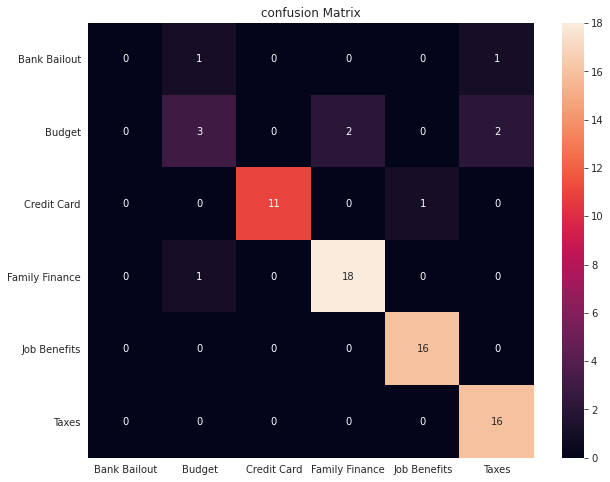

In [591]:
predict = log_clsfr_ovr.predict(X_test_bow)
cm = metrics.confusion_matrix(test_y, predict)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, xticklabels=target_label, yticklabels=target_label)
plt.title('confusion Matrix')
plt.show()

## Decision tree

In [594]:
#Tree based models 
from sklearn.tree import DecisionTreeClassifier

In [595]:
cv_AUC = []  #this list stores AUC on CV data for different hyperparamter values
train_AUC = [] #stores AUC on Train data for different hyperparameter values
depth = [1, 5, 10, 50, 100, 500, 1000]
min_samples_split=[5, 10, 100, 500]

#for each depth
for dept in depth:
    
    #storing auc score for each depth and all min_split to below list
    train_auc = []
    cv_auc = []
        
    #train model on for evry min samples split
    for min_split in min_samples_split:
        
        #here i'm choosing splitter=random just because we have large dimenionality so choosing randomly 
        #will require less computional power
        clsfr = DecisionTreeClassifier(splitter="random", max_depth=dept, min_samples_split=min_split)
        clsfr.fit(X_train_bow, train_y)
        
        #predicitng probablity score to compute AUC score on Train itself
        probablity_score = clsfr.predict_proba(X_train_bow)
        auc_score = metrics.roc_auc_score(train_y, probablity_score[:, :], multi_class='ovr')
        
        #storing AUC to train_AUC
        train_auc.append(auc_score)
        
        
        #predicting probablity score to compute AUC on CV 
        probablity_score = clsfr.predict_proba(X_test_bow)
        auc_score = metrics.roc_auc_score(test_y, probablity_score[:, :], multi_class='ovr')
        
        #storing AUC to cv_AUC
        cv_auc.append(auc_score)
    
    #appending list of AUC score on train and CV for each depth and min_sample_split
    cv_AUC.append(cv_auc)
    train_AUC.append(train_auc)

In [598]:
#print AUC on train & CV data
for i in range(len(depth)):
    for j in range(len(min_samples_split)):
        print("For depth={} & min samples split={}; AUC on Train={} & CV={}".format(depth[i], min_samples_split[j], train_AUC[i][j], cv_AUC[i][j]))

For depth=1 & min samples split=5; AUC on Train=0.6995835723185602 & CV=0.650880027233056
For depth=1 & min samples split=10; AUC on Train=0.6495925525861412 & CV=0.6334318917455709
For depth=1 & min samples split=100; AUC on Train=0.7100425156289241 & CV=0.7331174680169218
For depth=1 & min samples split=500; AUC on Train=0.5 & CV=0.5
For depth=5 & min samples split=5; AUC on Train=0.9702037988478982 & CV=0.8185231723289538
For depth=5 & min samples split=10; AUC on Train=0.9758431522760794 & CV=0.8938861588071029
For depth=5 & min samples split=100; AUC on Train=0.77981976267553 & CV=0.7219293409768676
For depth=5 & min samples split=500; AUC on Train=0.5 & CV=0.5
For depth=10 & min samples split=5; AUC on Train=0.9990361122673593 & CV=0.7794320581125448
For depth=10 & min samples split=10; AUC on Train=0.9899506765870059 & CV=0.7841047513950473
For depth=10 & min samples split=100; AUC on Train=0.8211523749168546 & CV=0.7846089150342191
For depth=10 & min samples split=500; AUC on T

In [612]:
clsfr = DecisionTreeClassifier(splitter="best", max_depth=10, min_samples_split=5)
clsfr.fit(X_train_bow, train_y)

#predicitng probablity score to compute AUC score on Train itself
probablity_score = clsfr.predict_proba(X_train_bow)
auc_score = metrics.roc_auc_score(train_y, probablity_score[:, :], multi_class='ovr')

probablity_score = clsfr.predict_proba(X_test_bow)
auc_score_ = metrics.roc_auc_score(test_y, probablity_score[:, :], multi_class='ovr')

print(auc_score, auc_score_)

0.9993392369972675 0.8209956112311501


In [616]:
#we'll upsample the data and try NB model with same parameters
bank_ballout = data_uncontracted[data_uncontracted['class_label']=='Bank Bailout']

(6, 3)

In [614]:
data_uncontracted.class_label.value_counts()

Family Finance    63
Taxes             54
Job Benefits      54
Credit Card       41
Budget            22
Bank Bailout       6
Name: class_label, dtype: int64

In [18]:
uncontracted_vectorizer = CountVectorizer(stop_words=stopwords_list, ngram_range=(1,2))
uncontracted_vectorizer.fit(X_train.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [19]:
X_train_bow = uncontracted_vectorizer.transform(X_train.values)
X_test_bow = uncontracted_vectorizer.transform(X_test.values)

In [20]:
X_train_bow.shape
#no using bigram so vector size has increased significantly 

(168, 61077)

In [21]:
X_test_bow.shape

(72, 61077)

In [25]:
label_encoder.classes_

array(['Bank Bailout', 'Budget', 'Credit Card', 'Family Finance',
       'Job Benefits', 'Taxes'], dtype=object)

In [24]:
test_y[1]

5

In [40]:
#CV
alpha_cv = []     #stores log(alpha) for plotting
auc_cv = []    #stores auc value Test

alpha_ = []  #stores alpha vaslue

alpha_tr = []     #stores log(alpha) for plotting 
auc_tr = []       #stores AUC Score on Train

i = 0.01 #alpha value starting range

while i<=1:
    print(i) 
    NB = MultinomialNB(alpha = i)
    ovr_NB = OneVsRestClassifier(NB)    
    ovr_NB.fit(X_train_bow, train_y)
    
    #Train Data
    predicted = ovr_NB.predict_proba(X_train_bow)   #returns probablity score
    # print(predicted.shape)
    auc = metrics.roc_auc_score(train_y, predicted[:, :], multi_class='ovr')
    auc_tr.append(auc)
    alpha_tr.append(math.log(i))
    
    # #Cv Data
    predicted_ = ovr_NB.predict_proba(X_test_bow)   #returns probablity score
    # print(predicted_)
    # print(predicted_.shape)
    auc_ = metrics.roc_auc_score(test_y, predicted_[:, :], multi_class='ovr')
    auc_cv.append(auc_)
    alpha_cv.append(math.log(i))
    
    
    alpha_.append(i)
    
    i *= 10
    
    
#printing the alpha and corresponding AUC value
print("AUC Score on CV:")
for x in range(0, len(alpha_)):
    print("Alpha: {}, AUC: {}".format(alpha_[x], auc_cv[x]))

print("\nAUC Score on Train:")
for x in range(0, len(alpha_)):
    print("Alpha: {}, AUC: {}".format(alpha_[x], auc_tr[x]))

0.01
0.1
1.0
AUC Score on CV:
Alpha: 0.01, AUC: 0.8522664835164836
Alpha: 0.1, AUC: 0.8956730769230768
Alpha: 1.0, AUC: 0.8292124542124543

AUC Score on Train:
Alpha: 0.01, AUC: 1.0
Alpha: 0.1, AUC: 1.0
Alpha: 1.0, AUC: 1.0


In [42]:
# train final model with optimal alpha = 0.1
NB = MultinomialNB(alpha = 0.1)
ovr_NB = OneVsRestClassifier(NB)    
ovr_NB.fit(X_train_bow, train_y)

#Train Data
predicted = ovr_NB.predict_proba(X_train_bow)   #returns probablity score
# print(predicted.shape)
auc = metrics.roc_auc_score(train_y, predicted[:, :], multi_class='ovr')
print('AUC with alpha = 0.1 on train : ', auc)

# #Cv Data
predicted_ = ovr_NB.predict_proba(X_test_bow)   #returns probablity score
# print(predicted_.shape)
auc_ = metrics.roc_auc_score(test_y, predicted_[:, :], multi_class='ovr')
print('AUC with alpha = 0.1 on test : ', auc_)

AUC with alpha = 0.1 on train :  1.0
AUC with alpha = 0.1 on test :  0.8956730769230768


In [44]:
target_label = label_encoder.classes_

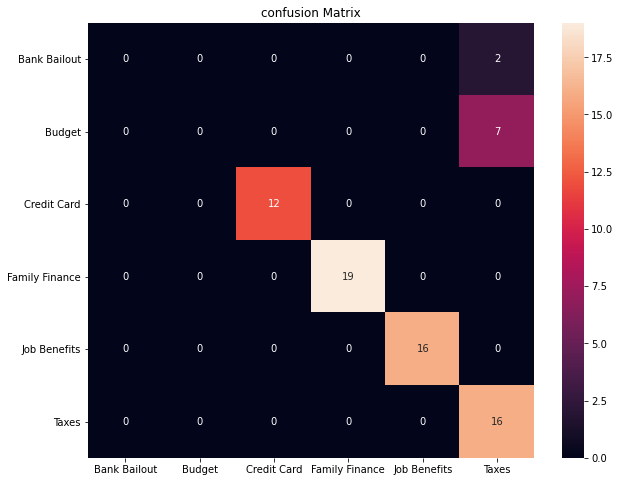

In [45]:
predict = ovr_NB.predict(X_test_bow)
cm = metrics.confusion_matrix(test_y, predict)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, xticklabels=target_label, yticklabels=target_label)
plt.title('confusion Matrix')
plt.show()

# Deep Learning Bert

In [231]:
! pip install transformers

     |████████████████████████████████| 1.9MB 5.8MB/s 
     |████████████████████████████████| 3.2MB 22.4MB/s 
     |████████████████████████████████| 890kB 53.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=df577fa079d4468d1ec1474ee9b9546bd6a0d9f4cd3c6dcbcf804857ea3f5d1a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [323]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
#importing DistilBert
from transformers import DistilBertTokenizer, DistilBertModel 

### Split the data

In [250]:
#we'll have to split into train and test data
X_train, X_test, y_train, y_test = train_test_split(data_contracted['conv_script'], data_contracted['class_label'], test_size=0.30, stratify=data_contracted['class_label'])
print(X_train.shape, X_test.shape)

(168,) (72,)


### Load the Distillbert tokenizer from hugging face

In [305]:
model = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model, do_lower_case=True, add_special_tokens=True, max_length=512, pad_to_max_length=True)

In [301]:
ss = ' '
inputs = tokenizer.encode_plus(ss, add_special_tokens=True, max_length=512, pad_to_max_length=True,  return_attention_mask=True, return_token_type_ids=True)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


### Helper methods to convert text into encoded sequence

In [307]:
def break_up_text(text):
  text_1 = ' '.join(text.split()[0:460])
  text_2 = ' '.join(text.split()[460:460*2])
  text_3 = ' '.join(text.split()[460*2:460*3])
  text_4 = ' '.join(text.split()[460*3:460*4])

  return text_1, text_2, text_3, text_4

def perfrom_tokenization(part_of_text, tokenizer):
  inputs = tokenizer.encode_plus(part_of_text, add_special_tokens=True, max_length=512, pad_to_max_length=True,  return_attention_mask=True, return_token_type_ids=True)
  return inputs

In [308]:
def tokenize_data(data, tokenizer):
  input_ids_1, input_masks_1, input_segments_1 = [],[],[]
  input_ids_2, input_masks_2, input_segments_2 = [],[],[]
  input_ids_3, input_masks_3, input_segments_3 = [],[],[]
  input_ids_4, input_masks_4, input_segments_4 = [],[],[]

  for sentence in data.values:
    sentence_1, sentence_2, sentence_3, sentence_4 = break_up_text(sentence)

    inputs = perfrom_tokenization(sentence_1, tokenizer)
    input_ids_1.append(inputs['input_ids'])
    input_masks_1.append(inputs['attention_mask'])
    input_segments_1.append(inputs['token_type_ids'])

    inputs = perfrom_tokenization(sentence_2, tokenizer)
    input_ids_2.append(inputs['input_ids'])
    input_masks_2.append(inputs['attention_mask'])
    input_segments_2.append(inputs['token_type_ids'])

    inputs = perfrom_tokenization(sentence_3, tokenizer)
    input_ids_3.append(inputs['input_ids'])
    input_masks_3.append(inputs['attention_mask'])
    input_segments_3.append(inputs['token_type_ids'])

    inputs = perfrom_tokenization(sentence_4, tokenizer)
    input_ids_4.append(inputs['input_ids'])
    input_masks_4.append(inputs['attention_mask'])
    input_segments_4.append(inputs['token_type_ids'])

  #convert all to numpy
  input_ids_1, input_masks_1, input_segments_1 = np.asarray(input_ids_1, dtype='int32'), np.asarray(input_masks_1, dtype='int32'), np.asarray(input_segments_1, dtype='int32')
  input_ids_2, input_masks_2, input_segments_2 = np.asarray(input_ids_2, dtype='int32'), np.asarray(input_masks_2, dtype='int32'), np.asarray(input_segments_2, dtype='int32')
  input_ids_3, input_masks_3, input_segments_3 = np.asarray(input_ids_3, dtype='int32'), np.asarray(input_masks_3, dtype='int32'), np.asarray(input_segments_3, dtype='int32')
  input_ids_4, input_masks_4, input_segments_4 = np.asarray(input_ids_4, dtype='int32'), np.asarray(input_masks_4, dtype='int32'), np.asarray(input_segments_4, dtype='int32')

  return input_ids_1, input_masks_1, input_segments_1, input_ids_2, input_masks_2, input_segments_2, input_ids_1, input_masks_3, input_segments_3, input_ids_4, input_masks_4, input_segments_4 

In [330]:
input_ids_1_tr, input_masks_1_tr, input_segments_1_tr, input_ids_2_tr, input_masks_2_tr, input_segments_2_tr, input_ids_3_tr, input_masks_3_tr, input_segments_3_tr, input_ids_4_tr, input_masks_4_tr, input_segments_4_tr = tokenize_data(X_train, tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [334]:
input_ids_1_test, input_masks_1_test, input_segments_1_test, input_ids_2_test, input_masks_2_test, input_segments_2_test, input_ids_3_test, input_masks_3_test, input_segments_3_test, input_ids_4_test, input_masks_4_test, input_segments_4_test = tokenize_data(X_test, tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [324]:
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55. Maxium allowed input length is 512
max_seq_length = 512

#Bert takes 3 input to give embedding for the sentence
#1. input word ids vector - Sequence of words represented as integers basically. 
#2. mask input vector - This is like for padding. If padding then what we'll do is simply mention 0 to make each input of same length
#3. Segment vector - This is useful when we have two setence problem. Since here only one so all the entries would be 0.
#If we are giving only one sentence for the classification, total seg vector is 0. 

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
#We'll load it with the help of tensorflow_hub
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#initialize the Bert model. Here we're using only the Pooled Output. Pooled output is output corresponding to [CLS]
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1, Total size: 423.26MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'.


In [325]:
X_train_pooled_output_1=bert_model.predict([input_ids_1_tr,input_masks_1_tr,input_segments_1_tr])

In [332]:
X_train_pooled_output_2=bert_model.predict([input_ids_2_tr,input_masks_2_tr,input_segments_2_tr])
X_train_pooled_output_3=bert_model.predict([input_ids_3_tr,input_masks_3_tr,input_segments_3_tr])
X_train_pooled_output_4=bert_model.predict([input_ids_4_tr,input_masks_4_tr,input_segments_4_tr])


In [331]:
input_ids_3_tr.shape

(168, 512)

In [326]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 512)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [333]:
pickle.dump((X_train_pooled_output_1, X_train_pooled_output_2, X_train_pooled_output_3, X_train_pooled_output_4),open('bert_train_embedding_final.pkl','wb'))

In [335]:
X_test_pooled_output_1=bert_model.predict([input_ids_1_test, input_masks_1_test, input_segments_1_test])
X_test_pooled_output_2=bert_model.predict([input_ids_2_test, input_masks_2_test, input_segments_2_test])
X_test_pooled_output_3=bert_model.predict([input_ids_3_test, input_masks_3_test, input_segments_3_test])
X_test_pooled_output_4=bert_model.predict([input_ids_4_test, input_masks_4_test, input_segments_4_test])

In [338]:
pickle.dump((X_test_pooled_output_1, X_test_pooled_output_2, X_test_pooled_output_3, X_test_pooled_output_4),open('bert_test_embedding_final.pkl','wb'))